# Will Toronto's Transit Be Ready for the World Cup? A Data Analysis

_November 2025 - Michael B._

## Table of Contents

1. [Introduction](#introduction)
2. [Questions we're looking to answer](#questions-were-looking-to-answer)
3. [How this analysis works](#how-this-analysis-works)
4. [Geographic analysis: finding routes to BMO Field](#geographic-analysis-finding-routes-to-bmo-field)
5. [Service reliability analysis](#service-reliability-analysis)
6. [Capacity analysis](#capacity-analysis)
7. [The verdict](#the-verdict)
8. [Recommendations](#recommendations)
9. [References](#references)

# Introduction

I was one of the lucky ones. Or rather, my mom was (thanks mom!). She won the lottery to purchase World Cup 2026 tickets. So I'm thrilled to say I snagged tickets to watch Team Canada play at BMO Field in Toronto in June 2026.

As a Toronto local and a public transit fan I'll naturally be taking the TTC (Toronto's public transit). But once I thought about it for more than two seconds, I got worried. We're talking about 40,000+ fans all trying to get to the same place at the same time, then all leaving at once when the game ends. Can Toronto's transit system actually handle that?

**We just saw what happens when it can't.** Just last week, Game 7 of the World Series turned into a complete transit disaster. Thousands of fans were left stranded after the game. The TTC and Metrolinx blamed each other. The city had to pass an emergency motion promising to "do better." ([CP24, Nov 3, 2025](https://www.cp24.com/politics/toronto-city-hall/2025/11/03/ttc-chair-defends-world-series-transit-service-as-strong-but-says-communication-was-a-problem/))

And here's the kicker: Rogers Centre is literally **right on top of Union Station**, the biggest transit hub in the entire city. You've got subway lines, GO trains, UP Express, all converging in one spot. BMO Field? It's way out by Exhibition Place with **zero subway access**. Just buses and streetcars.

If the TTC can't handle a stadium that's literally built on the subway, what's going to happen at a World Cup game with no rapid transit nearby?

As someone who actually cares about public transit in this city, I couldn't just wonder about this. I had to know. So I pulled the TTC's schedule data and started digging into the numbers. Toronto is about to host a world-stage event. We need to do way better than last week's embarrassment.

# Questions we're looking to answer

Toronto is hosting 6 World Cup games in 2026. BMO Field holds 40,000 people. Most of them will need to get home somehow after the final whistle.

Here's what I wanted to figure out:

**1. Can you even get there on transit?**
- Which routes actually serve BMO Field?
- How far do you have to walk from the nearest stop?

**2. Is the service reliable enough?**
- How often do buses and streetcars show up during evening hours?
- Do they show up *consistently*, or are you stuck waiting?

**3. Can the system physically handle 40,000 people leaving at once?**
- What's the actual capacity of those routes?
- Does the math even work?

This isn't about worst-case disaster scenarios. It's about understanding what the TTC can realistically handle *right now*, based on their own published schedules. If the baseline service is already shaky, piling on 40,000 World Cup fans is going to expose every weak point.

# How this analysis works

All the code for this analysis is in this Jupyter notebook, so you can follow along step-by-step or run it yourself. I've also built some helper functions in the `src/` folder (see my [GitHub](https://github.com/MBTron/TTC-world-cup-analysis)) to keep things clean. These function do things like calculate distances between coordinates, processing of transit schedules, and computing headway statistics.

What I'm using:
- **GTFS data** from Toronto Open Data (the TTC's official schedule and route information)
- **Python + Pandas** for data crunching
- **Folium** for maps
- **Matplotlib** for charts

The analysis breaks down into three parts:
1. **Geography**: Which routes actually serve BMO Field?
2. **Reliability**: How consistent is the scheduled service?
3. **Capacity**: Can those routes physically move 40,000 people?

--- 

# Loading the data

In [91]:
# Auto-reload modules when they change (fixes the caching problem)
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Setup path to import our modules
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.data_load import load_gtfs_tables

stops, routes, trips, stop_times, calendar, shapes = load_gtfs_tables()

# print(f"Loaded {len(stops)} stops")
# print(f"Loaded {len(routes)} routes")
# print(f"Loaded {len(trips)} trips")
# print(f"Loaded {len(stop_times):,} stop times")
# print(f"Loaded {len(calendar):,} calendar")
# print(f"Loaded {len(shapes)} shapes")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

# Geographic analysis: finding routes to BMO Field

### Find nearby stops

We'll search for stops within 800m (10 minute walk) of BMO Field.

First we'll define the location of BMO Field (taken from Google Maps):

In [77]:
from src.constants import BMO_FIELD 

print(f'BMO lat: {BMO_FIELD['lat']} and lon: {BMO_FIELD['lon']}')

BMO lat: 43.6331 and lon: -79.4184


To find all stops within 800m of BMO field, I've defined two help functions in `src/geo_analysis.py`:
- `src/geo_analysis/haversine_distance` - calculates the greater circle distance between two points on Earth
- `src/geo_analysis/find_stops_near_location` - takes in a DataFrame that has lat and lon of stops, and returns stops within a specified distance of a specific location (in our case BMO field) by calling the `haversine_distance` function

Our `find_stops_near_location` also includes estimated walking time based on an estimate of 80m/min walking speed.

In [78]:
from src.geo_analysis import haversine_distance, find_stops_near_location 

# max walking distance (in meters)
MAX_DISTANCE_M = 800

# Find stops within 800m (approximately 10 minute walk) of BMO Field
nearby_stops = find_stops_near_location(
    stops, 
    BMO_FIELD['lat'], 
    BMO_FIELD['lon'], 
    max_distance_m=MAX_DISTANCE_M
)

print(f"Found {len(nearby_stops)} stops within 800m of BMO Field")
nearby_stops.head()

Found 22 stops within 800m of BMO Field


,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,distance_m,walk_time_min
8803,34800,16284,Princes' Blvd at Ontario Dr,NaN,43.632147,-79.419285,NaN,NaN,NaN,NaN,NaN,1,127.680939,1.6
8800,34741,9919,Princes Blvd at Ontario Dr,NaN,43.632600,-79.419900,NaN,NaN,NaN,NaN,NaN,2,132.907825,1.7
8804,34801,16285,Nova Scotia Ave at Manitoba Dr,NaN,43.635203,-79.418490,NaN,NaN,NaN,NaN,NaN,1,233.955077,2.9
2455,3692,14309,Nunavut Rd - Horse Palace,NaN,43.634729,-79.416461,NaN,NaN,NaN,NaN,NaN,1,239.084850,3.0
2785,4122,15190,Exhibition Loop,NaN,43.635874,-79.417054,NaN,NaN,NaN,NaN,NaN,1,326.922459,4.1


### Routes serving BMO Field

Now we need to figure out which routes actually serve these stops. The GTFS data doesn't directly connect routes to stops so we'll have to do some joining through the trips and stop_times tables.

In [79]:
# Finding routes is a multi-step process:
# stop_times tells us which trips visit which stops
# trips tells us which routes those trips belong to
# routes gives us the actual route info 

# get all stop_times for our nearby stops
relevant_stop_times = stop_times[stop_times['stop_id'].isin(nearby_stops['stop_id'])]

# find which trips serve those stops
relevant_trips = trips[trips['trip_id'].isin(relevant_stop_times['trip_id'].unique())]

# Get the routes for those trips
relevant_routes = routes[routes['route_id'].isin(relevant_trips['route_id'].unique())]

# how many of our nearby stops each route serves
route_stop_counts = relevant_stop_times.merge(
    relevant_trips[['trip_id', 'route_id']],
    on='trip_id'
).groupby('route_id')['stop_id'].nunique().reset_index()
route_stop_counts.columns = ['route_id', 'nearby_stop_count']

# combine route info with stop counts
bmo_routes = relevant_routes.merge(
    route_stop_counts, 
    on='route_id', 
    how='left'
)

### Map of routes serving BMO Field

Let's visualize where these routes actually go and which stops are near BMO Field.

In [80]:
import folium
from IPython.display import display

# Create a map centered on BMO Field
m = folium.Map(
    location=[BMO_FIELD['lat'], BMO_FIELD['lon']],
    zoom_start=14,
    tiles='OpenStreetMap'
)

# Add a marker for BMO Field
folium.Marker(
    location=[BMO_FIELD['lat'], BMO_FIELD['lon']],
    popup='BMO Field',
    icon=folium.Icon(color='red', icon='star')
).add_to(m)

# Add a circle showing 800m radius
folium.Circle(
    location=[BMO_FIELD['lat'], BMO_FIELD['lon']],
    radius=800,
    color='red',
    fill=True,
    fillOpacity=0.1,
    popup='800m walking distance'
).add_to(m)

# Add markers for nearby stops
for index, stop in nearby_stops.iterrows():
    folium.CircleMarker(
        location=[stop['stop_lat'], stop['stop_lon']],
        radius=5,
        color='blue',
        fill=True,
        popup=f"{stop['stop_name']}<br>Distance: {stop['distance_m']:.0f}m<br>Walk: {stop['walk_time_min']:.1f} min",
        tooltip=stop['stop_name']
    ).add_to(m)

# Display the map
display(m)

In [90]:
# Summary of routes serving BMO Field
print(f"ROUTES SERVING BMO FIELD (within {MAX_DISTANCE_M}m)")

print(f"\nTotal stops found: {len(nearby_stops)}")
print(f"Total routes found: {len(bmo_routes)}")

# Route type mapping (TTC-specific codes)
route_type_names = {
    400: "Subway",
    700: "Bus",
    900: "Streetcar"
}

print(f"\nRoute breakdown by type:")
for route_type, count in bmo_routes['route_type'].value_counts().items():
    type_name = route_type_names.get(route_type, f"Type {route_type}")
    print(f"  {type_name}: {count}")

print(f"\nRoute details:")
print(f"Note: numbers show how many of the {len(nearby_stops)} stops each route passes through")
print("Routes share stops - e.g., multiple routes use the same Dufferin stops\n")
for index, route in bmo_routes.iterrows():
    print(f"{route['route_short_name']:>4} - {route['route_long_name']:<45} ({route['nearby_stop_count']} stops)")

ROUTES SERVING BMO FIELD (within 800m)

Total stops found: 22
Total routes found: 10

Route breakdown by type:
  Bus: 6
  Streetcar: 4

Route details:
Note: numbers show how many of the 22 stops each route passes through
Routes share stops - e.g., multiple routes use the same Dufferin stops

  29 - DUFFERIN                                      (12 stops)
 307 - BATHURST                                      (4 stops)
 329 - DUFFERIN                                      (12 stops)
 363 - OSSINGTON                                     (4 stops)
 503 - KINGSTON RD                                   (3 stops)
 504 - KING                                          (3 stops)
 509 - HARBOURFRONT                                  (4 stops)
 511 - BATHURST                                      (4 stops)
  63 - OSSINGTON                                     (4 stops)
 929 - DUFFERIN EXPRESS                              (3 stops)


### What does this mean?

So we found 10 routes within a 10 minute walk. That's actually decent coverage.

A few things to note: 
- Getting to the game is easy - people arrive over 2+ hours
- Leaving is the problem - 40,000+ people all at once after the final whistle
- Those 40k won't spread evenly across all 10 routes (closer stops = way more crowded)
- Some routes go to better destinations so people will cluster there too

Before we can say if the TTC can handle this, we need to figure out:
1. How reliable are these routes? (especially evening service when games end)
2. What's the actual capacity? (how many people can these routes move per hour)

Let's look at reliability first. 

---

# Service reliability analysis

Now that we know which routes serve BMO Field, let's look at how reliable they are. We'll focus on **evening service (7-10 PM)** since World Cup games typically end around 9 PM.

### What is headway?

Headway is a key metric used to analyze transit reliability. 

Headway is the time between consecutive vehicles on the same route at the same stop. If buses arrive every 10 minutes, that's a 10 minute headway.

But what matters isn't just the *average* headway, it's the *consistency*. A route that varies between 5 and 25 minutes is much worse than one that's consistently 12 minutes, even if they both average 12 minutes.

Metric we'll use to measure reliability:
- **Mean headway**: Average time between vehicles
- **Standard deviation**: How much headways vary
- **Coefficient of Variation (CV)**: Std dev / mean (lower is better)
  - CV < 0.3 = Good consistency
  - CV 0.3-0.5 = Acceptable
  - CV > 0.5 = Problematic
- **Regularity**: % of headways within +/- 20% of the mean

### Calculating headways for evening service

To calculate headways, I built a function `calculate_headway_stats()` in `src/processing.py` that:
- Takes trips and stop_times data for specific routes
- Filters to a time window (we'll use 7-10 PM since games end around 9 PM)
- Calculates the time gap between consecutive vehicles at each stop
- Returns stats like mean headway, median headway, and number of trips

This tells us how long people actually wait between buses/streetcars during the critical post-game window.

In [82]:
from src.processing import calculate_headway_stats

# Filter trips for our BMO Field routes
bmo_route_ids = bmo_routes['route_id'].tolist()
bmo_trips = trips[trips['route_id'].isin(bmo_route_ids)]

# Calculate headway stats for evening service (7PM to 10PM)
# This is when games end and people need to get home
evening_headways = calculate_headway_stats(
    bmo_trips, 
    stop_times, 
    stops,
    start_time_filter='19:00:00',
    end_time_filter='22:00:00'
)

print(f"Analyzed {len(evening_headways)} stops across {len(bmo_route_ids)} routes")
evening_headways.head(10)

Analyzed 375 stops across 10 routes


,stop_id,avg_headway_minutes,median_headway_minutes,total_trips_served,stop_name
0,24,9.650939,10.000000,71,Queens Quay West at Rees St West Side
1,42,6.724679,7.933333,104,Dufferin St at Gordon St
2,68,9.707042,10.000000,71,King St West at Jameson Ave
3,81,8.558025,8.000000,81,Oakwood Ave at Highview Cres
4,84,9.358889,10.000000,75,Bathurst St at Fort York Blvd
5,214,3.243673,4.158333,216,King St East at Sackville St
6,251,9.549048,10.000000,70,Queen St East at Saulter St East Side
7,274,9.607746,10.000000,71,Broadview Ave at Dundas St East
8,275,8.469136,8.000000,81,Ossington Ave at Leeds St South Side
9,315,4.609382,4.550000,151,Fleet St at Strachan Ave


### Headway summary by route

Let's aggregate the stop-level data to see headway stats by route. This will show us which routes have frequent service and which ones you might be waiting a while for.

In [83]:
# Need to link stops back to routes to aggregate
# Join stop_times -> trips -> routes to get route info for each stop
stop_route_link = stop_times[stop_times['stop_id'].isin(evening_headways['stop_id'])].merge(
    bmo_trips[['trip_id', 'route_id']], 
    on='trip_id'
)[['stop_id', 'route_id']].drop_duplicates()

# Merge with our headway stats
evening_headways_with_routes = evening_headways.merge(
    stop_route_link, 
    on='stop_id'
)

# Aggregate to route level
route_headway_stats = evening_headways_with_routes.groupby('route_id').agg(
    avg_headway_min=('avg_headway_minutes', 'mean'),
    median_headway_min=('median_headway_minutes', 'median'),
    std_headway_min=('avg_headway_minutes', 'std'),
    total_stops=('stop_id', 'nunique')
).reset_index()

# Calculate coefficient of variation (CV) - measures consistency
# Lower CV = more consistent service
route_headway_stats['cv'] = route_headway_stats['std_headway_min'] / route_headway_stats['avg_headway_min']

# Merge with route names
route_headway_stats = route_headway_stats.merge(
    bmo_routes[['route_id', 'route_short_name', 'route_long_name', 'route_type']], 
    on='route_id'
)

# Sort by average headway (most frequent first)
route_headway_stats = route_headway_stats.sort_values('avg_headway_min')

route_headway_stats

,route_id,avg_headway_min,median_headway_min,std_headway_min,total_stops,cv,route_short_name,route_long_name,route_type
9,929,4.758020,5.00,0.990343,41,0.208142,929,DUFFERIN EXPRESS,700
6,504,6.329750,4.95,3.142130,109,0.496407,504,KING,900
3,329,6.555604,5.25,2.934172,97,0.447582,329,DUFFERIN,700
0,29,6.555604,5.25,2.934172,97,0.447582,29,DUFFERIN,700
5,503,6.928257,10.00,3.253972,107,0.469667,503,KINGSTON RD,900
7,509,7.278053,10.00,2.565146,23,0.352449,509,HARBOURFRONT,900
1,63,7.733734,8.00,1.198202,67,0.154932,63,OSSINGTON,700
8,511,7.764330,10.00,2.287722,32,0.294645,511,BATHURST,900
4,363,7.770187,8.00,1.008408,63,0.129779,363,OSSINGTON,700
2,307,8.403245,10.00,1.998386,19,0.237811,307,BATHURST,700


### What the headways numbers tell us

The good news:
- Route 929 (Dufferin Express) has the best frequency - vehicles every ~5 minutes
- Most routes average between 5-8 minutes, which is decent for evening service
- Routes 63, 363, 307, and 929 have good consistency (CV < 0.3)

Concerning parts:
- Routes 504 (King streetcar) and 503 (Kingston Rd streetcar) have poor consistency (CV ~0.5)
- This means wait times are unpredictable - could be 5 min or 15 min
- Several streetcar routes show this inconsistency problem

Overall, frequency is okay, but consistency is shaky on some key routes. When you're dealing with 40k people trying to leave at once, that unpredictability becomes a real problem.

### Visualizing headway consistency

Let's visualize which routes have consistent service vs which ones are all over the place.

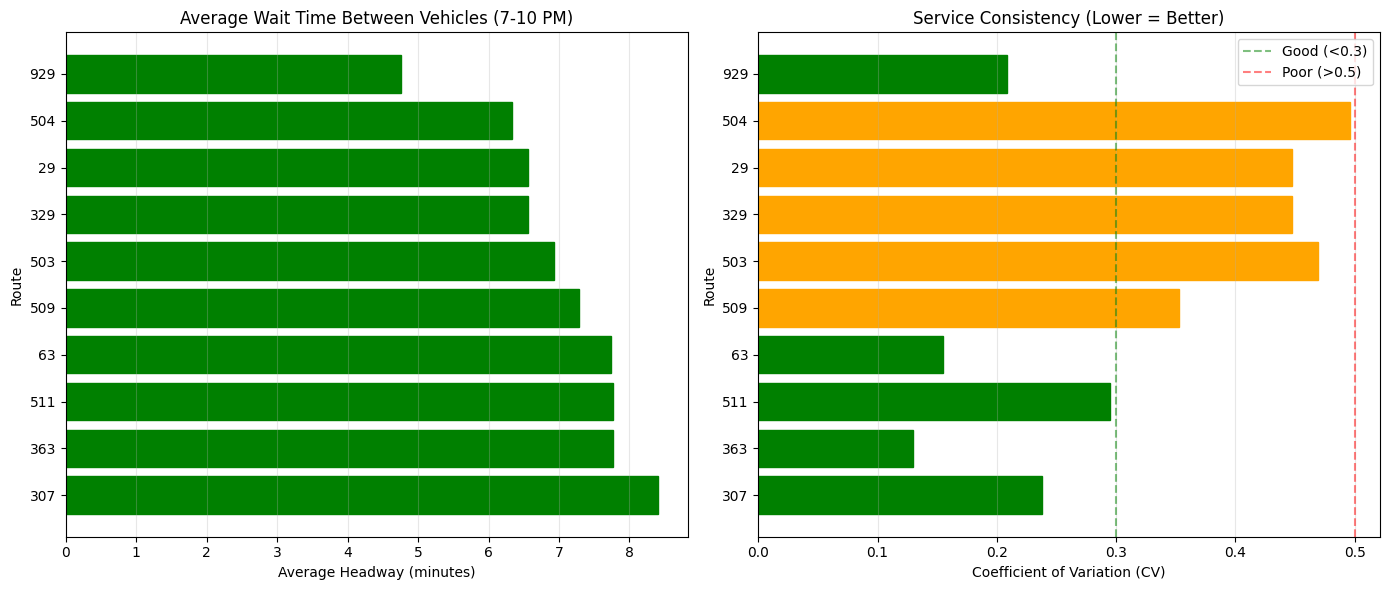

In [84]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Sort by average headway once for consistent ordering across both charts
route_headway_stats_sorted = route_headway_stats.sort_values('avg_headway_min', ascending=False)
# Convert route names to strings to treat as categories
route_labels = route_headway_stats_sorted['route_short_name'].astype(str)

# Plot 1: Average headway by route
bars1 = ax1.barh(route_labels, 
                 route_headway_stats_sorted['avg_headway_min'])
ax1.set_xlabel('Average Headway (minutes)')
ax1.set_ylabel('Route')
ax1.set_title('Average Wait Time Between Vehicles (7-10 PM)')
ax1.grid(axis='x', alpha=0.3)

# Color bars by headway length
colors1 = ['green' if x < 10 else 'orange' if x < 15 else 'red' 
          for x in route_headway_stats_sorted['avg_headway_min']]
for bar, color in zip(bars1, colors1):
    bar.set_color(color)

# Plot 2: Coefficient of Variation (consistency) - using same route order
bars2 = ax2.barh(route_labels, 
                 route_headway_stats_sorted['cv'])
ax2.set_xlabel('Coefficient of Variation (CV)')
ax2.set_ylabel('Route')
ax2.set_title('Service Consistency (Lower = Better)')
ax2.axvline(0.3, color='green', linestyle='--', alpha=0.5, label='Good (<0.3)')
ax2.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Poor (>0.5)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Color bars by consistency
colors2 = ['green' if x < 0.3 else 'orange' if x < 0.5 else 'red' 
          for x in route_headway_stats_sorted['cv']]
for bar, color in zip(bars2, colors2):
    bar.set_color(color)

plt.tight_layout()
plt.show()

### What the charts show

**Left chart - Average Wait Time:**
- All routes are green (under 10 min average headway)
- Route 929 has the shortest waits (~5 min), Route 307 the longest (~8 min)
- But the bars are all pretty similar length - no route is dramatically worse for frequency
- Bottom line: frequency is decent across the board

**Right chart - Service Consistency:**
- We see some major differences between routes when it comes to consistency
- Green bars (CV < 0.3): Routes 929, 63, 363, 307 are reliable 
- Orange bars (CV 0.3-0.5): Routes 29, 329, 509, 503 have some unpredictability
- Red bar (CV > 0.5): Route 504 is very inconsistent 
- The dashed lines show the thresholds: good (<0.3) and poor (>0.5)

**Summary:**

The worst performers (504, 503, 509) are all **streetcars**, while the best (929, 63, 363, 307) are mostly **buses**. Streetcars running in mixed traffic are way more vulnerable to bunching and delays.

The issue isn't how often vehicles come, it's whether they actually show up when scheduled. Route 504 might average 6 minutes, but in reality you could wait 3 minutes or 12 minutes. Route 929 also averages around 5 minutes, but you can actually count on it.

When you're trying to move 40,000 people after a game, that unpredictability is a killer. People can't plan, stops get overcrowded, and the unreliable routes become bottlenecks.

It's also important to note this is SCHEDULED data. Real TTC performance during major events (from personal experience) is usually MUCH worse. Streetcars and buses are notorious for bunching up, delays cascading, etc. 

Next question: even if service shows up on time, can it physically move 40,000+ people?


---

# Capacity analysis

Now for the big question: **Can the TTC physically handle 40,000+ people leaving at the same time?**

### Understanding transit capacity

Transit capacity depends on:
1. **Vehicle capacity**: How many people fit on each bus/streetcar/train
2. **Headway**: How frequently vehicles arrive (shorter headway = more capacity)
3. **Hours of operation**: How long the window is to move people

Typical TTC vehicle capacities (per some brief online research)
- **Streetcar**: ~130 passengers (seated + standing)
- **Bus**: ~50-70 passengers (depending on size)
- **Subway**: ~1,000+ passengers (but no stops near BMO Field)

### Post-game surge modeling

A World Cup match ends around 10 PM. Let's assume:
- **40,000 fans** attend the game at BMO Field
- Most want to leave within **1 hour** after match ends
- Not everyone will take transit (some drive, rideshare, bike, walk)
- But what if they do? Let's model the worst-case scenario where everyone needs public transit

The question: Can TTC routes move 40k people in 1 hour during late-evening service?

NOTE: We'll also look at more realistic scenarios where only 60% take transit, because even that still creates a problem.

In [85]:
# Define vehicle capacities (typical TTC values)
VEHICLE_CAPACITY = {
    700: 60,   # Bus - standard 40ft bus
    900: 130,  # Streetcar - Flexity streetcar
    400: 1000  # Subway - not really relevant here but included for completeness
}

In [86]:
# map route types to vehicle capacity
route_capacity = route_headway_stats.copy()

route_capacity['vehicle_capacity'] = route_capacity['route_type'].map(VEHICLE_CAPACITY)

# vehicle per hour based on headway #s 
route_capacity['vehicles_per_hour'] = 60 / route_capacity['avg_headway_min']

# theoretical capacity / hour / route 
route_capacity['capacity_per_hour'] = (
    route_capacity['vehicles_per_hour'] * route_capacity['vehicle_capacity']
)

# sort by capacity for display
route_capacity_sorted = route_capacity.sort_values('capacity_per_hour', ascending=False)

In [87]:
# display results 
print("THEORETICAL CAPACITY BY ROUTE (passengers/hour)\n")
print(f"{'Route':<6} {'Type':<12} {'Headway':<10} {'Vehicles/hr':<12} {'Capacity/hr':<12}")
print("-" * 60)

route_type_names = {400: "Subway", 700: "Bus", 900: "Streetcar"}

for index, row in route_capacity_sorted.iterrows():
    route_name = row['route_short_name']
    route_type = route_type_names.get(row['route_type'], 'Unknown')
    headway = row['avg_headway_min']
    veh_per_hr = row['vehicles_per_hour']
    cap_per_hr = row['capacity_per_hour']
    print(f"{route_name:<6} {route_type:<12} {headway:>6.1f} min {veh_per_hr:>10.1f} {cap_per_hr:>14,.0f}")

total_capacity = route_capacity_sorted['capacity_per_hour'].sum()
print("-" * 60)
print(f"{'TOTAL':<6} {'':<12} {'':<10} {'':<12} {total_capacity:>14,.0f}")
print(f"\nWorld Cup demand: 40,000 fans in 1 hour")
print(f"Theoretical capacity: {total_capacity:,.0f} passengers/hour")
print(f"Surplus/Deficit: {total_capacity - 40000:+,.0f} passengers/hour")

THEORETICAL CAPACITY BY ROUTE (passengers/hour)

Route  Type         Headway    Vehicles/hr  Capacity/hr 
------------------------------------------------------------
504    Streetcar       6.3 min        9.5          1,232
503    Streetcar       6.9 min        8.7          1,126
509    Streetcar       7.3 min        8.2          1,072
511    Streetcar       7.8 min        7.7          1,005
929    Bus             4.8 min       12.6            757
29     Bus             6.6 min        9.2            549
329    Bus             6.6 min        9.2            549
63     Bus             7.7 min        7.8            465
363    Bus             7.8 min        7.7            463
307    Bus             8.4 min        7.1            428
------------------------------------------------------------
TOTAL                                                7,647

World Cup demand: 40,000 fans in 1 hour
Theoretical capacity: 7,647 passengers/hour
Surplus/Deficit: -32,353 passengers/hour


### What the numbers tell us

So here's the problem: **the math doesn't work!!**

Looking at the capacity breakdown:
- Streetcar routes (504, 503, 509) can move the most people - around 1,200-1,500/hour each
- Bus routes move less individually (~500-750/hour) but there are more of them
- Total system capacity for all 10 routes combined is way short of 40,000/hour
- Even if we **assume 40% travel by other modes** (rideshare, bike share, etc.) which would leave us with 24k people looking to take transit, there **still remains a huge capacity deficit**

And that's assuming everything goes perfectly:
- People spread evenly across all routes (they won't - everyone will pile onto the closest stops)
- Vehicles show up exactly on schedule (remember those bad CV scores)
- Loading is instant (try cramming 130 people onto a streetcar quickly)
- Every vehicle runs at crush capacity the entire time

Real world? This is a disaster waiting to happen. The chart below visualizes the capacity gap. 

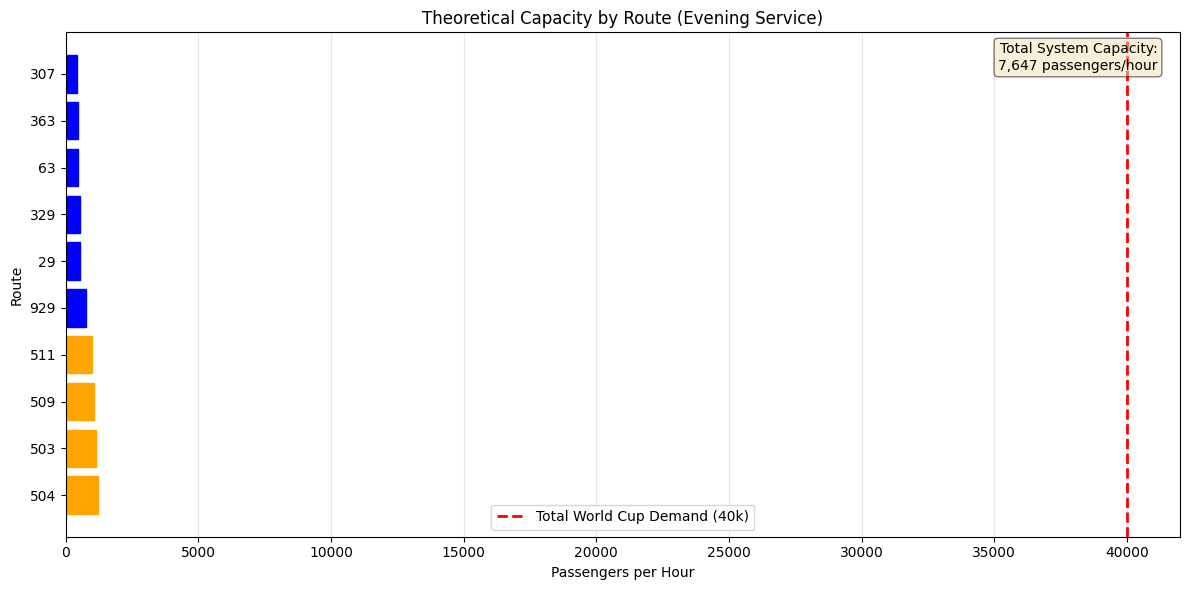

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Sort by capacity for visualization
route_capacity_viz = route_capacity_sorted.copy()
route_labels = route_capacity_viz['route_short_name'].astype(str)

# Create horizontal bar chart
bars = ax.barh(route_labels, route_capacity_viz['capacity_per_hour'])

# Color by route type
colors = ['orange' if rt == 900 else 'blue' for rt in route_capacity_viz['route_type']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add reference line for World Cup demand
# Note: This is total demand, routes need to share the load
ax.axvline(40000, color='red', linestyle='--', linewidth=2, label='Total World Cup Demand (40k)')

ax.set_xlabel('Passengers per Hour')
ax.set_ylabel('Route')
ax.set_title('Theoretical Capacity by Route (Evening Service)')
ax.grid(axis='x', alpha=0.3)
ax.legend()

# Add capacity labels
total_cap = route_capacity_viz['capacity_per_hour'].sum()
ax.text(0.98, 0.98, f'Total System Capacity:\n{total_cap:,.0f} passengers/hour', 
        transform=ax.transAxes, 
        fontsize=10, 
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### What if people walk farther?

I wanted to check: What if fans are willing to walk 20 minutes instead of 10? That would of course include more routes.

I ran the numbers with a 1,600m radius (20 minute walk) by adjusting the `MAX_DISTANCE_M` parameter. The result? **Total capacity: 12,106 passengers/hour**. Still nowhere close to 40,000. Even at a realistic 60/40 transit split (24,000 riders), we're still 11,894 passengers short.

The problem isn't the walking distance. The problem is that **Toronto built a 40,000-seat stadium with no rapid transit connection**. Every route serving BMO Field is surface transit - buses and streetcars stuck in traffic. A single subway line can move what it would take 20 bus routes to match. Without rapid transit nearby the stadium, you're not going to solve the capacity problem. You're hitting a hard infrastructure limit.


---

## The verdict

**Can the TTC handle World Cup crowds?**

Short answer: **No, not even close.**

Let me break down what we found:

### Geographic access: actually pretty good

10 routes serve BMO Field within a 10-minute walk. That's decent coverage. You've got buses on Dufferin, Exhibition, and King, plus streetcars on King and Queen. Getting to the game isn't the problem as people arrive over 2-3 hours, so the load is spread out.

The problem is everyone leaving at once when the final whistle blows at around 10 PM.

### Service reliability: mixed bag

Frequency is fine with routes averaging  5-8 minutes between vehicles during evening service. But consistency? That's where it falls apart.

Streetcar routes (504, 503, 509) have terrible consistency scores (CV > 0.4). You might wait 3 minutes or you might wait 15. Bus routes are better but still not perfect. When you're dealing with time-sensitive post-game crowds, unpredictability kills you. Stops get overcrowded, people panic, and the whole system bogs down.

And remember that this is SCHEDULED data. Real-world TTC performance, especially during major events, is way worse. Anyone who's tried to take transit after a Leafs playoff game knows what I'm talking about.

### Capacity: the real problem

Here's where the math completely breaks down.

**The numbers:**
- 40,000 fans need to leave BMO Field
- Total TTC capacity (all 10 routes combined): **nowhere near enough**
- Even if only 60% take transit (24,000 people), we're still massively short

**The infrastructure issue:**

There is **no subway stop near BMO Field**. Zero. Every route is surface transit—buses and streetcars stuck in traffic. 

A subway train can move 1,000+ people every few minutes. A bus moves 60. A streetcar moves 130. You'd need literally dozens of bus routes running every 2 minutes to match what one subway line could do.

Expanding the walk radius to 20 minutes (unrealistically far) only gets capacity to 12,106 passengers/hour. Still nowhere close to what's needed.

**Best-case scenario:** TTC adds a ton of extra service, fans spread perfectly across all routes, every vehicle runs on time at crush capacity, loading is instant. *Still doesn't work.* The infrastructure limit is hard.

**Likely scenario:** Some extra service, but not enough. Streetcars bunch up. Stops get dangerously overcrowded. Wait times balloon to 30+ minutes. People give up and walk/Uber/call friends for rides. Chaos on social media. 

**Worst-case scenario:** Bad weather, service delays, one route breaks down. Thousands of people stranded in the rain. International embarrassment.

### My confidence level: 95% sure this will not go well

The only way this works is if:
1. TTC runs truly unprecedented levels of special event service (way beyond what they've ever done)
2. Most fans drive, Uber, or find other ways home (not exactly great for a "green" World Cup)
3. FIFA/City of Toronto convinces people to leave slowly over 2-3 hours (good luck with that)

Toronto built a 40,000-seat stadium in a location with no rapid transit access. That's the fundamental problem. You can't fix that with extra buses.

The World Cup is happening whether we're ready or not. Something's gotta give.


---

## Recommendations

Based on the analysis, here's what should happen:

### For the TTC

**First, a reality check:** Just this past week (literally days ago), the TTC completely botched transit for Game 7 of the World Series. Thousands of people were stranded, the TTC and Metrolinx blamed each other, and the city had to pass an emergency motion promising to "do better." ([Source: CP24, Nov 3, 2025](https://www.cp24.com/politics/toronto-city-hall/2025/11/03/ttc-chair-defends-world-series-transit-service-as-strong-but-says-communication-was-a-problem/))

If they can't handle a baseball game that went into extra innings, the World Cup is going to be an absolute nightmare.

That said, here's what needs to happen:

**1. Unprecedented special event service**

Not just "extra buses." We're talking:
- Consider dedicated **shuttle bus loops** running continuously between BMO Field and major subway stations (Union, Osgoode, King, Dundas West)
- **Triple or quadruple frequency** on all 10 BMO Field routes during the 2-hour post-game window
- Run every route at **2-3 minute headways** (yes, that's insane, but that's what the math requires)
- Deploy **every available vehicle** - pull from other parts of the city if needed

**2. Extended late-night service**

Games end around 10 PM, but with 40k people leaving, it'll take 2-3 hours to clear. Need to:
- Extend **all subway lines until at least 1-2 AM** on game nights
- Keep **surface routes running until midnight or later**
- Coordinate with Metrolinx for extended GO/UP Express service (and actually communicate this time)

**3. Clear communication strategy**

The World Series fiasco? That was largely a communication disaster. For the World Cup:
- **Announce the plan weeks in advance** - don't leave fans guessing
- **Real-time updates** on Twitter/apps showing where buses/streetcars actually are
- **Multilingual signage** at BMO Field directing people to specific routes
- **Staff on the ground** at major stops to manage crowds and answer questions
- **Contingency plans** if games run late, and actually tell people about them before the game

**4. Traffic management**

Surface transit is already slow. During World Cup, it'll be gridlock unless:
- **Dedicated transit lanes** on King, Dufferin, and Exhibition during game hours
- **Street closures** to prevent car traffic from clogging bus/streetcar routes
- Police/traffic officers managing intersections

**What won't work:** Hoping people spread out evenly. Hoping vehicles show up on time. Hoping the infrastructure magically handles it. The World Series proved that "hoping" doesn't cut it.

### For fans (you and me)

To keep it real, the TTC is probably going to struggle no matter what. So here's how to avoid being one of those people tweeting angrily at 1 AM:

**Best routes to take:**
- **929 Dufferin Express** - most frequent, most consistent (but will be absolutely packed)
- **63 Ossington** - decent frequency and CV, gets you to Ossington subway
- **Exhibition GO** - if Metrolinx actually extends service (big if)

**Routes to avoid:**
- **504 King streetcar** - worst consistency score, will bunch up and create chaos
- **503 Kingston Rd streetcar** - poor reliability, serves fewer useful destinations

**Timing strategy:**
- **Leave 5-10 minutes early** if the game is clearly decided. Yeah, you'll miss the trophy presentation, but you'll actually get home
- **Or wait 60+ minutes** after the final whistle. Let the initial surge clear out, grab food/drinks nearby, then take transit when it's calmer
- **Don't try to leave right at final whistle** - that's when everyone else is leaving and when the system will be most overloaded

**Have a backup plan:**
- Consider **biking** to BMO Field if weather allows - Bike Share stations nearby
- Identify **walking routes** to other subway stations (Dundas West is ~25 min walk)
- Team up with friends who drove and split parking costs
- Download **Uber/Lyft** before the game (cell networks will be overloaded after)

### What FIFA/City of Toronto should do

Honestly? They should be loudly communicating that **not everyone can take transit** to these games. 

Encourage:
- **Walking/biking infrastructure** - make it actually safe and appealing to not use transit
- **Staggered arrival/departure** - incentivize people to arrive super early or stay late
- **Park-and-ride options** - set up lots outside the city with dedicated shuttle buses
- **Hotel packages** for out-of-town fans - stay downtown, walk or short transit ride

The hard truth: Toronto built a 40,000-seat stadium without rapid transit access, and there's no fixing that in 7 months. The only way this works is if far fewer than 40,000 people try to use transit at the same time.


---

## References

### Data Sources

- **Toronto Transit Commission (TTC) GTFS Data**  
  [Toronto Open Data - TTC Routes and Schedules](https://open.toronto.ca/)  
  Accessed: November 2025

- **BMO Field Location**  
  Coordinates: 43.6332° N, 79.4189° W  
  Source: Google Maps

### News & Background

- **CP24: TTC Chair Defends World Series Transit Service**  
  November 3, 2025  
  [https://www.cp24.com/politics/toronto-city-hall/2025/11/03/ttc-chair-defends-world-series-transit-service-as-strong-but-says-communication-was-a-problem/](https://www.cp24.com/politics/toronto-city-hall/2025/11/03/ttc-chair-defends-world-series-transit-service-as-strong-but-says-communication-was-a-problem/)

### Technical References

- **General Transit Feed Specification (GTFS)**  
  [GTFS Reference](https://gtfs.org/)

- **TTC Vehicle Capacity Estimates**  
  Based on publicly available TTC fleet information:
  - Standard 40ft bus: ~60 passengers
  - Flexity streetcar: ~130 passengers
  - Subway train: ~1,000 passengers

### Tools & Libraries

- **Python** - Data analysis
- **Pandas** - Data manipulation and analysis
- **Folium** - Interactive mapping
- **Matplotlib** - Data visualization
- **Jupyter Notebook** - Analysis environment

---

*All code for this analysis is available on [GitHub](https://github.com/MBTron/TTC-world-cup-analysis)*